In [2]:
import os
import findspark
findspark.init()

In [1]:
# ASSIGNMENT 3
# T22-03-08344

!pip install -q findspark

In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.linalg import DenseVector, SparseVector
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Spark MLlib
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#======================================================================================
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [5]:
# Start the Spark session
spark = SparkSession.builder.master("local[*]").appName("TextClassification").getOrCreate()

In [6]:
# Fetch dataset
data = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers', 'quotes'))
for key, value in data.items():
    print(key)

data.data[:3]

data
filenames
target_names
target
DESCR


["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per

In [7]:
# Create pandas DataFrame
pdf = pd.DataFrame({'text': data.data, 'label': data.target})

In [8]:
# Convert to Spark DataFrame for para
df = spark.createDataFrame(pdf)
df.show(5, truncate=1000)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# Create pandas DataFrame
pdf = pd.DataFrame({'text': data.data, 'label': data.target})
# Tokenize
tokenizer = Tokenizer(inputCol="text", outputCol="words")
# Remove stopwords eg (and, the, or , etc)
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
# HashingTermFreq - converts words to fixed-length feature vectors
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
# InvDocFre - downscale frequent words[less impor]
idf = IDF(inputCol="rawFeatures", outputCol="features")
# Create Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
# Fit and transform the data
pipeline_model = pipeline.fit(df)
processed_df = pipeline_model.transform(df)

In [11]:
# Select only the necessary columns
processed_df.select("label", "features").show(5, truncate=True)
processed_df.count()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|   10|(10000,[453,524,6...|
|    3|(10000,[85,126,22...|
|   17|(10000,[39,136,15...|
|    3|(10000,[53,126,38...|
|    4|(10000,[228,302,4...|
+-----+--------------------+
only showing top 5 rows



18846

In [12]:
# Sample ~2000 rows to keep t-SNE fast
sampled = processed_df.select("label", "features").limit(2000)

# Convert to Pandas DataFrame
pandas_df = sampled.toPandas()

In [13]:
# Convert features (SparseVector) to dense NumPy arrays
def vector_to_array(v):
    if isinstance(v, SparseVector):
        return v.toArray()
    return np.array(v)
X = np.vstack(pandas_df['features'].apply(vector_to_array))
y = pandas_df['label'].values

In [14]:
# t-[SNE-t-distributed Stochastic Neighbor Embedding.] dimensionality reduction[visuzlizing hig dm data]
tsne = TSNE(n_components=2, random_state=1965, perplexity=3) #Perplexity  ranges from 5-50, high(50)->global r/ship
X_embedded = tsne.fit_transform(X)

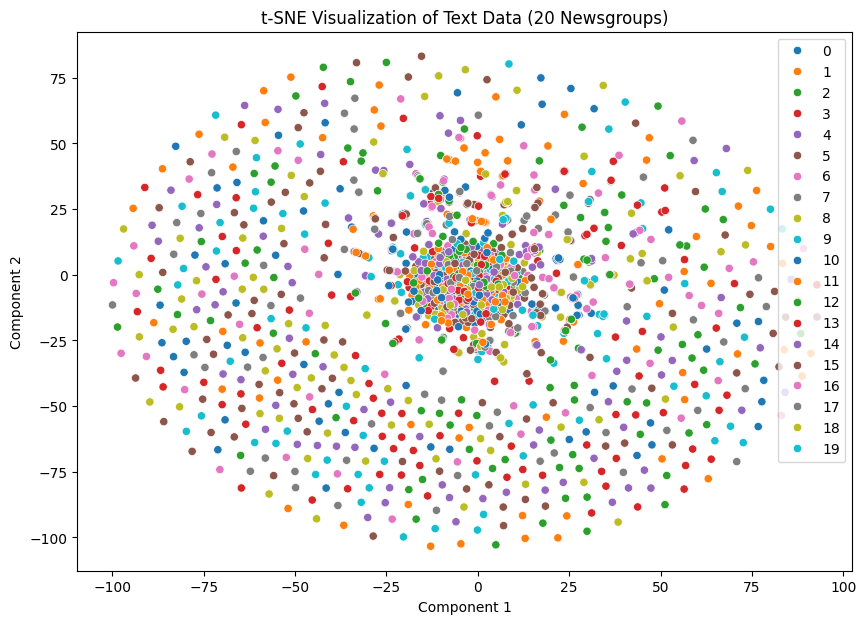

Test Set Accuracy = 0.5939


In [15]:
# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette="tab10", legend='full')
plt.title("t-SNE Visualization of Text Data (20 Newsgroups)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Prepare final dataset (label + features only)
final_data = processed_df.select("label", "features")
# Split into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed= 1234)
# Define logistic regression model
lr = LogisticRegression(maxIter=20, regParam=0.1) # Play with 'regParam' and explore other classification models in "pyspark.ml.classification" to see if there would be any improvement in accuracy.
# Train model
lr_model = lr.fit(train_data)
# Make predictions
predictions = lr_model.transform(test_data)
# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Set Accuracy = {accuracy:.4f}")

CONCLUSION

To better understand the high-dimensional TF-IDF features, t-SNE was applied with a perplexity of 3. This visualization reduces the features to two dimensions and shows how different classes are distributed in the feature space. The clustering effect suggests that some topics are linearly separable.

The combination of dimensionality reduction (t-SNE) and ensemble models (Random Forest) proves effective for text classification tasks in big data environments. Further tuning and experimenting with deep learning approaches could offer additional improvements.